In [106]:
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

import pandas as pd
from pathlib import Path

In [185]:
#Here, the data should be a 2 x n array where the first column is the corresponding time point.
# The RealData will be plotted in a scatter fashion, whereas the ModelData in a continuous fashion.
def Plot_FittedSolution(Fig, RealData, ModelData,
                        axes_labels=["Year", "Monolingual Speakers"], title=" "):
    ax = Fig.gca()
    
    #First we plot the real data:
    x_arr = RealData[0]
    y_arr = RealData[1]
    ax.scatter(x_arr, y_arr, marker="x", color="r")
    
    #The regression data:
    x_arr2 = ModelData[0]
    y_arr2 = ModelData[1]
    ax.plot(x_arr2, y_arr2)
    
    #Now we configure the plot to look nice and add the labels:
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_xlabel(axes_labels[0],fontsize=16,fontweight='bold')
    ax.set_ylabel(axes_labels[1],fontsize=16,fontweight='bold')
    ax.set_title(title)
    
    return Fig

To do: (1) fix the Luck-Mehta simulation, (2) input data for other competitions, (3) think of presentation

# Modelling Language Competition with Dynamical Systems

Gabriel Agostini, Gary Casey, and Theresa Brown

Code reference: https://github.com/TavoGLC/DataAnalysisByExample/tree/master/ParameterEstimation

November 18th, 2020

## 1. Data

We load the data for the $4$ cases we would like to test this model against. The data will be an $n\times 5$ dataframe whose columns are respectively the time array $T$, the total number of monolingual speakers of the preferred language $X_1$, the number of monolingual speakers of the minority language $X_2$, the number of bilingual speakers, and the total population at the given time.


(1) English-Welsh competition in Wales ($n = 28$), data collected from multiple sources:

In [142]:
#NOTE that the data for 2002-2019 comes from a single source, and might disagree with the previous
# data. Those are rows of idx 10-27. I create new dataframes for each.

welsh_data = pd.read_csv(Path("data", "welsh.csv"))
welsh_hist_data = welsh_data[:10]
welsh_new_data = welsh_data[10:]

## 2. Numerical ODE Solvers and Regression

I use the odeint function in scipy.integrate with the Runge-Kutta order $4$ method. For parameter fitting, I use the curve_fit function in scipy.optimize.

In [107]:
from scipy.integrate import odeint
from scipy.optimize import curve_fit

Regression on the model assumes we have a function of the form f(x_arr, params) which returns the array of y at that given x. In the case of a dynamical system, we input the time series data and return the value of $x_1$ and $x_2$ at each of those points. We will need to do some adjustment to define what exactly is the function we want to optimize.

### 2.1. Abrams-Strogatz Model

The Abrams-Strogatz Model (2003) uses the following equation:

$$\dfrac{d x}{dt} = cs (1-x)x^a - c(1-s)x(1-x)^a$$

There are three parameters here, namely $c$, $a$ and $s$. The equation for the second language will not be necessary as they are decoupled and $x_1 = 1 - x_2$.

In [253]:
def AS_Model(x, c, s, a):
    x = abs(x) #just in case we reachead below zero, since we are exponentiating
    y = abs(1-x)
    s_y = 1-s
    F = c*s*y*(x**a) - c*s_y*x*(y**a)
    return F

The model uses $x_1$ and $x_2$ as the fraction of speakers. We normalize the data:

In [248]:
data = welsh_hist_data.values[:,2]/np.sum(welsh_hist_data.values[:,2])
IC = data[0]

#Formatting the time:
raw_dataTime = welsh_hist_data.values[:,0]
t0 = raw_dataTime[0]
tf = raw_dataTime[-1]

dataTime = raw_dataTime - t0 #Discrete time that matches the datapoints
SolverTime = np.linspace(0, tf-t0+1) #Continuous-ish time to plot the solution fitted

RealData = np.array([dataTime, data])

Using the odeint function, we create a function that, given values of the parameters, the initial condition, and a time array, outputs the value of one of the variables at those time points:

In [249]:
def AS_ModelSolver(IC, t, c, s, a):
    #It is more stable to pass to the odeint method a function without additional parameters:
    def LocalModel(IC, t):
        return AS_Model(IC, c, s, a)
    #Now we call the solver, since no method is specified this uses RK45
    Solution = odeint(LocalModel, IC, t)
    return Solution[:,0]

We define the objective function:

In [250]:
def AS_ModelFit(t, c, s, a):
    return AS_ModelSolver(IC, t, c, s, a)

Now we need functions to optimize the initial guess:

In [255]:
#Measures the squared error between the data and the fit given an initial parameter guess
def AS_SquaredError(InitialParameterGuess, SolverTime=dataTime, data=data, IC=IC):
    try:
        #Some guesses will result in an error or an invalid integration 
        #this ensures that the error is estimated only for valid solutions 
        tempAS_params = curve_fit(AS_ModelFit, SolverTime, data, p0=InitialParameterGuess)[0]
        tempSolution = AS_ModelSolver(IC, SolverTime,
                                      tempAS_params[0], tempAS_params[1], tempAS_params[2])
        error = [(pred-real)**2 for pred,real in zip(tempSolution, data)] 
    except RuntimeError:
        #Based on the scale of the data the following list of values will be
        # large enough to be rejected as a solution 
        error = [np.sum(data),np.sum(data)]
    return sum(error)

#Random selection of the initial guess values 
def AS_RandomSearch(Iterations, n_param=3):
    nIt=Iterations 
    GuessContainer=[]
    ErrorContainer=[]   
    for k in range(nIt):
        
        lGuess=[np.random.uniform(low=0,high=2) for val in range(n_param)]
        lerror=AS_SquaredError(lGuess)
        
        GuessContainer.append(lGuess) #Contains the list of random initial values 
        ErrorContainer.append(lerror) #List of the errors 
    
    minError=np.min(ErrorContainer) #Min error value
    #print(minError)
    minLocation=[j for j in range(nIt) if ErrorContainer[j]==minError] #Returns the location of the min value in the list
    #print(minLocation)
    bestGuess=GuessContainer[minLocation[0]] #Best initial value guess 
    
    return ErrorContainer,bestGuess 

#Get the best guess:
errs, AS_bestGuess = AS_RandomSearch(10)

0.0005810675562921622
[8]


Using these functions we can perform the fitting:

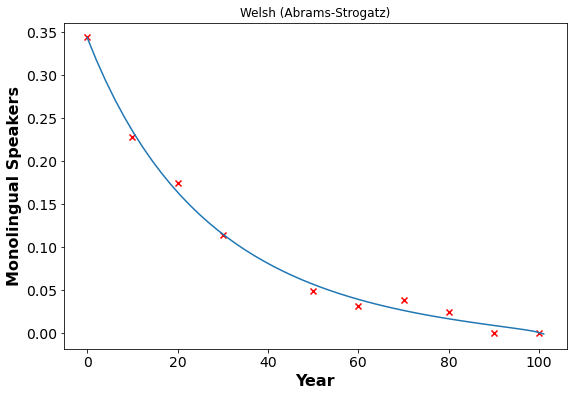

In [257]:
AS_bestParams = curve_fit(AS_ModelFit, dataTime, data, p0=AS_bestGuess)[0]
AS_fitSolution = AS_ModelSolver(IC, SolverTime,
                                AS_bestParams[0], AS_bestParams[1], AS_bestParams[2])

AS_ModelData = np.array([SolverTime, AS_fitSolution])

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, RealData, AS_ModelData, title="Welsh (Abrams-Strogatz)")

### 2.2. Zhang-Gong Model

The Zhang-Gong Model (2003) uses the following equations:

$$\begin{cases}
\dfrac{d x_1}{dt} = r_1x_1\left(1 - \dfrac{1}{N_1}x_1 - \dfrac{\sigma_1}{N_2}x_2\right)
\\
\dfrac{d x_2}{dt} = r_2x_2\left(1 - \dfrac{1}{N_2}x_2 - \dfrac{\sigma_2}{N_1}x_1\right)
\end{cases}$$

There are six parameters here, namely $r_1, r_2, N_1, N_2, \sigma_1, \sigma_2$.

In [193]:
def ZG_Model(X, r_1, r_2, sigma_1, sigma_2, N_1, N_2):
    F1 = r_1*X[0]*(1 - X[0]/N_1 - sigma_1*X[1]/N_2)
    F2 = r_2*X[1]*(1 - X[1]/N_2 - sigma_2*X[0]/N_1)
    return [F1, F2]

The model uses $x_1$ and $x_2$ as the number of speakers. Thus the data is ready:

In [194]:
data = welsh_hist_data.values[:,2]
IC = np.array([welsh_hist_data.values[0,1], welsh_hist_data.values[0,2]])

#Formatting the time:
raw_dataTime = welsh_hist_data.values[:,0]
t0 = raw_dataTime[0]
tf = raw_dataTime[-1]

dataTime = raw_dataTime - t0 #Discrete time that matches the datapoints
SolverTime = np.linspace(0, tf-t0+1) #Continuous-ish time to plot the solution fitted

RealData = np.array([dataTime, data])

Using the odeint function, we create a function that, given values of the parameters, the initial condition, and a time array, outputs the value of one of the variables at those time points:

In [195]:
def ZG_ModelSolver(IC, t, r_1, r_2, sigma_1, sigma_2, N_1, N_2, sol=1):
    #It is more stable to pass to the odeint method a function without additional parameters:
    def LocalModel(IC, t):
        return ZG_Model(IC, r_1, r_2, sigma_1, sigma_2, N_1, N_2)
    #Now we call the solver, since no method is specified this uses RK45
    Solution = odeint(LocalModel, IC, t)
    return Solution[:,sol]

We define the objective function:

In [258]:
def ZG_ModelFit(t, r_1, r_2, sigma_1, sigma_2, N_1, N_2):
    return ZG_ModelSolver(IC, t, r_1, r_2, sigma_1, sigma_2, N_1, N_2)

To optimize the initial guess, we use Zhang and Gong's estimation techniques. To compute $r$ they use (when data is available), the language inheritance principle I:

$$r_1 = p(L_1) = p(L_1L_1) + \dfrac{1}{2}p(L_1L_2)\quad\text{and}\quad r_2 = p(L_2) = p(L_2L_2) + \dfrac{1}{2}p(L_1L_2)$$

Where $p(XY)$ is the relative proportion of speakers of the languages $X$ and $Y$ in the population.

In [197]:
#Take the array L to be a 1x3 array with the size of monol population for L1,
# for L2, and bilingual respectively
def R(L):
    tot = np.sum(L)
    p_11 = L[0]/tot
    p_22 = L[1]/tot
    p_12 = L[2]/tot
    
    return np.array([p_11 + 0.5*p_12, p_22 + 0.5*p_12])

Sigma can be estimated according to the language diffusion principle:

$$\sigma_1 = \dfrac{Q_2}{Q_1}\exp\left(\dfrac{d^2_1 - d^2_2}{4}\right)\quad\text{and}\quad
\sigma_2 = \dfrac{Q_1}{Q_2}\exp\left(\dfrac{d^2_2 - d^2_1}{4}\right)$$

Where $d_i$ is the distance of the population from the language center and $Q_i$ is the speaker population at the cultural center.

In [198]:
def Sigma(Q, D):
    if type(D) == type(None):
        D = np.zeros_like(Q)
    sigma_1 = (Q[1]/(Q[0]+0.1))*math.exp((D[0]**2 - D[1]**2)/4)
    sigma_2 = (Q[0]/(Q[1]+0.1))*math.exp((D[1]**2 - D[0]**2)/4)
    return np.array([sigma_1, sigma_2])

The estimation for $N$ is simply the maximum population. We then get the best initial guess:

In [199]:
#NOTE: pass the data as an array, not dataframe
def ZG_estimate(data, t0_idx=0, tf_idx=-1, D=None):
    #Select the part of the data we will use based on the initial and final indices:
    if t0_idx != 0:
        data = data[t0_idx:]
    if tf_idx != -1:
        data = data[:tf_idx]
    #First we select the carrying capacity as max sum of monolingual speakers:
    N = np.max(np.add(data[:,1], data[:,2]))
    N_arr = np.array([N, N])
    #For the R parameters:
    L = np.array([data[0, 1], data[0, 2], data[0, 3]])
    r = R(L)
    #For the mutual influence, we use the distance provided (or None) and for Q we use the IC:
    Q = np.array([data[0, 1], data[0, 2]])
    #print(Q)
    sigma = Sigma(Q, D)
    return np.array([r[0], r[1], sigma[0], sigma[1], N_arr[0], N_arr[1]])

ZG_bestGuess = ZG_estimate(welsh_hist_data.values)

Using these functions we can perform the fitting:

/Users/gsagostini/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


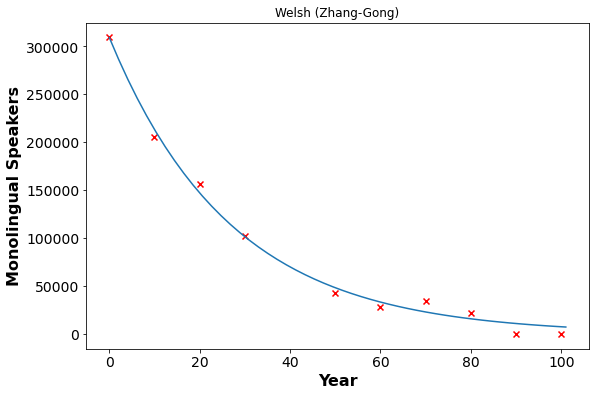

In [200]:
ZG_bestParams = curve_fit(ZG_ModelFit, dataTime, data, p0=ZG_bestGuess)[0]
ZG_fitSolution = ZG_ModelSolver(IC, SolverTime,
                                ZG_bestParams[0], ZG_bestParams[1], ZG_bestParams[2],
                                ZG_bestParams[3], ZG_bestParams[4], ZG_bestParams[5])

ZG_ModelData = np.array([SolverTime, ZG_fitSolution])

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, RealData, ZG_ModelData, title="Welsh (Zhang-Gong)")

### 2.3. Luck-Mehta Model

The Luck-Mehta Model (2020) uses the following equations:

$$\begin{cases}
\dfrac{d x_1}{dt} = x_1\cdot (1- x_1 - qx_2 + Cx_2)
\\
\dfrac{d x_2}{dt} = x_2\cdot (1- x_2 - qx_1 + Cx_1)
\end{cases}$$

There are two parameters here, namely $q, C$.

In [262]:
def LM_Model(X, q, C):
    F1 = X[0]*(1 - X[0] - q*X[1] + C*X[1])
    F2 = X[1]*(1 - X[1] - q*X[0] - C*X[0])
    return [F1, F2]

The model uses $x_1$ and $x_2$ as the number of speakers. Thus the data is ready:

In [263]:
data = welsh_hist_data.values[:,2]
IC = np.array([welsh_hist_data.values[0,1], welsh_hist_data.values[0,2]])

#Formatting the time:
raw_dataTime = welsh_hist_data.values[:,0]
t0 = raw_dataTime[0]
tf = raw_dataTime[-1]

dataTime = raw_dataTime - t0 #Discrete time that matches the datapoints
SolverTime = np.linspace(0, tf-t0+1) #Continuous-ish time to plot the solution fitted

RealData = np.array([dataTime, data])

Using the odeint function, we create a function that, given values of the parameters, the initial condition, and a time array, outputs the value of one of the variables at those time points:

In [264]:
def LM_ModelSolver(IC, t, q, C, sol=1):
    #It is more stable to pass to the odeint method a function without additional parameters:
    def LocalModel(IC, t):
        return LM_Model(IC, q, C)
    #Now we call the solver, since no method is specified this uses RK45
    Solution = odeint(LocalModel, IC, t)
    return Solution[:,sol]

We define the objective function:

In [265]:
def LM_ModelFit(t, q, C):
    return LM_ModelSolver(IC, t, q, C)

Now we need functions to optimize the initial guess:

In [284]:
#Measures the squared error between the data and the fit given an initial parameter guess
def LM_SquaredError(InitialParameterGuess, SolverTime=dataTime, data=data, IC=IC):
    try:
        #Some guesses will result in an error or an invalid integration 
        #this ensures that the error is estimated only for valid solutions 
        tempLMParams = curve_fit(LM_ModelFit, SolverTime, data, p0=InitialParameterGuess)[0]
        tempSolution = LM_ModelSolver(IC, SolverTime,
                                      tempLMParams[0],tempLMParams[1])
        error=[(pred-real)**2 for pred,real in zip(tempSolution, data)] 
    except RuntimeError:
        #Based on the scale of the data the following list of values will be
        # large enough to be rejected as a solution 
        error = [np.max(data),np.max(data)]
    return sum(error)

#Random selection of the initial guess values 
def LM_RandomSearch(Iterations, n_param=2):
    nIt=Iterations 
    GuessContainer=[]
    ErrorContainer=[]   
    for k in range(nIt):
        
        lGuess=[np.random.uniform(low=0,high=1) for val in range(n_param)]
        #print(lGuess)
        lerror=LM_SquaredError(lGuess)
        
        GuessContainer.append(lGuess) #Contains the list of random initial values 
        ErrorContainer.append(lerror) #List of the errors 
    
    minError=np.min(ErrorContainer) #Min error value 
    minLocation=[j for j in range(nIt) if ErrorContainer[j]==minError] #Returns the location of the min value in the list
    
    bestGuess=GuessContainer[minLocation[0]] #Best initial value guess 
    
    return ErrorContainer,bestGuess

#Get the best guess:
errs, LM_bestGuess = LM_RandomSearch(10)

Using these functions we can perform the fitting:

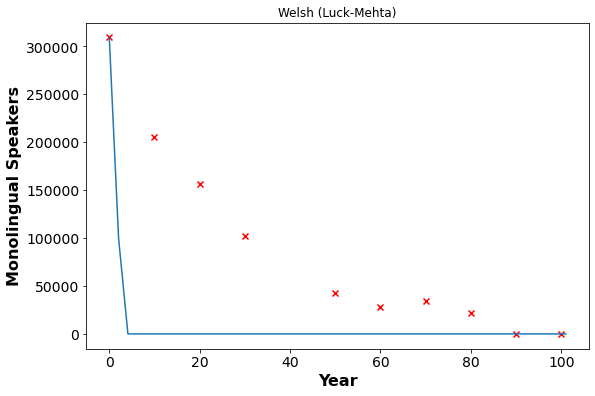

In [285]:
LM_bestParams = curve_fit(LM_ModelFit, dataTime, data, p0=LM_bestGuess)[0]
LM_fitSolution = LM_ModelSolver(IC, SolverTime,
                                LM_bestParams[0], LM_bestParams[1])

LM_ModelData = np.array([SolverTime, LM_fitSolution])

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, RealData, LM_ModelData, title="Welsh (Luck-Mehta)")